In [1]:
import multiprocessing
import tweepy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from config import *

In [2]:
# Search API
def crawl_tweet_dataframe(hashtag, count): 
    """
    Get KEY and ACCESS TOKEN from https://developer.twitter.com/en/apps
    
    Parameters:
        hashtag: the search query string of 500 characters maximum, including operators.
        count: the number of results to try and retrieve per page.
    """
    authentication = tweepy.OAuthHandler(CONSUMER_KEY, CONSUMER_SECRET)
    authentication.set_access_token(ACCESS_TOKEN, ACCESS_TOKEN_SECRET)
    api = tweepy.API(authentication, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)
    maxId = -1
    tweetCount = 0

    tweet_list = []
    while tweetCount < maxTweets: 
        if(maxId <= 0):
            newTweets = api.search(
                q=hashtag, count=tweetsPerQry, result_type="recent", tweet_mode="extended")
        else:
            newTweets = api.search(
                q=hashtag, count=tweetsPerQry, max_id=str(maxId - 1), result_type="recent", tweet_mode="extended")

        if not newTweets:
            print("Tweet Habis")
            break

        for tweet in newTweets:
            user = tweet.user.screen_name.encode('utf-8')
            content = tweet.full_text.encode('utf-8')
            date = tweet.created_at
            likes = tweet.favorite_count
            location = tweet.coordinates["coordinates"] if tweet.coordinates is not None else None
            tweet_list.append([user, content, date, likes, location])

        tweetCount += len(newTweets)
        maxId = newTweets[-1].id

    tweet_df = pd.DataFrame(tweet_list)
    tweet_df.columns = ["user", "text", "date", "likes", "location"]
    tweet_df["user"] = tweet_df["user"].apply(lambda x: x.decode("utf-8"))
    tweet_df["text"] = tweet_df["text"].apply(lambda x: x.decode("utf-8"))

    return tweet_df

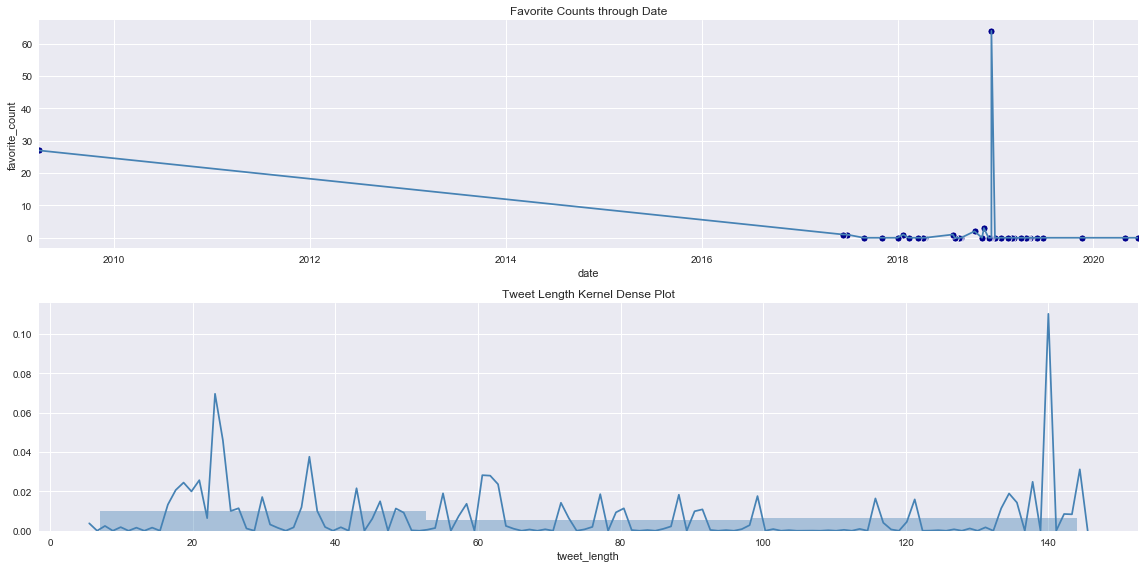

In [50]:
# Streaming API
class TwitterAuth():
    """
    Get authentication for Twitter.
    from config import CONSUMER_KEY, CONSUMER_SECRET, ACCESS_TOKEN, ACCESS_TOKEN_SECRET
    """
    def auth_twitter_app(self):
        auth = tweepy.OAuthHandler(CONSUMER_KEY, CONSUMER_SECRET)
        auth.set_access_token(ACCESS_TOKEN, ACCESS_TOKEN_SECRET)
        return auth

class MaxListener(tweepy.StreamListener):
    """
    This simple stream listener prints status text.
    """
    def __init__(self, tweets_filename):
        self.tweets_filename = tweets_filename
    
    def on_data(self, raw_data):
        self.process_data(raw_data)
        return True
    
    def process_data(self, raw_data):
        try:
            print(raw_data)
            with open(self.tweets_filename, 'a') as f:
                f.write(raw_data)
            return True
        except BaseException as e:
            print("Error on data: {}".format(e))
        return True 
        
    def on_error(self, status_code):
        if status_code == 420:
            return False
        
class MaxStreamer():
    """
    In Tweepy, an instance of tweepy.Stream establishes a streaming session and routes messages to StreamListener instance.
    
    Parameters:
        tweets_filename: json file name.
    """
    def __init__(self, tweets_filename):
        self.auth = TwitterAuth().auth_twitter_app()
        self.listener = MaxListener(tweets_filename=tweets_filename)
        self.stream = tweepy.Stream(auth=self.auth, listener=self.listener)
        
    def start(self, keyword):
        keyword_list = [keyword]
        self.stream.filter(track=keyword_list)
        
class TwitterClient():
    """
    Get my own tweets or others.
    
    Parameters:
        twitter_user: if twitter_user is set to None, it means capture my tweets. Instead, crawl twitter_user tweets. 
    """
    def __init__(self, twitter_user=None):
        self.auth = TwitterAuth().auth_twitter_app()
        self.twitter_client = tweepy.API(self.auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)
        self.twitter_user = twitter_user
        
    def get_twitter_client_api(self):
        return self.twitter_client
        
    def get_user_timeline_tweets(self, num_tweets):
        tweets = []
        for tweet in tweepy.Cursor(self.twitter_client.user_timeline, id=self.twitter_user).items(num_tweets):
            tweets.append(tweet)
        return tweets
    
    def get_friend_list(self, num_friends):
        friend_list = []
        for friend in tweepy.Cursor(self.twitter_client.friends, id=self.twitter_user).items(num_friends):
            friend_list.append(friend)
        return friend_list
    
    def get_home_timeline_tweets(self, num_tweets):
        home_timeline_tweets = []
        for tweet in tweepy.Cursor(self.twitter_client.home_timeline, id=self.twitter_user).items(num_tweets):
            home_timeline_tweets.append(tweet)
        return home_timeline_tweets
    
class TweetAnalyzer():
    """
    """
    def tweets_to_dataframe(self, tweets):
        df = pd.DataFrame()
        df["tweet"] = np.array([tweet.text for tweet in tweets])
        df["tweet_length"] = np.array([len(tweet.text) for tweet in tweets])
        df["id"] = np.array([tweet.id for tweet in tweets])
        df["geography"] = np.array([tweet.geo for tweet in tweets])
        df["favorite_count"] = np.array([tweet.favorite_count for tweet in tweets])
        df["retweet_count"] = np.array([tweet.retweet_count for tweet in tweets])
        df["date"] = np.array([tweet.created_at for tweet in tweets])
        df["source"] = np.array([tweet.source for tweet in tweets])
        return df
        
if __name__ == "__main__":
    """
    Jerome Hayden Powell (USA): JeromeHaydenPo2
    Mark Carney (UK): carneyms
    Haruhiko Kuroda (Japan): IvanWKljunak
    """
    # Analyse tweet
    tweet_analyzer = TweetAnalyzer()
    api = TwitterClient().get_twitter_client_api()
    tweets = api.user_timeline(screen_name="carneyms", count=100)
    df = tweet_analyzer.tweets_to_dataframe(tweets)
    
    # Some visualization
    plt.style.use("seaborn")
    plt.figure(figsize=(16, 8))
    plt.subplot(2, 1, 1)
    ax = sns.scatterplot(x="date", y="favorite_count", color="darkblue", data=df)
    sns.lineplot(x="date", y="favorite_count", color="steelblue", data=df)
    ax.set_xlim(df['date'].min(), df['date'].max())
    plt.title("Favorite Counts through Date")
    plt.subplot(2, 1, 2)
    sns.distplot(df["tweet_length"], color="steelblue", kde_kws={'bw': 0.5})
    plt.title("Tweet Length Kernel Dense Plot")
    plt.tight_layout()
    plt.show()

In [ ]:
tweetsPerQry = 100
maxTweets = 100000
hashtag = "#trump"

tweet_df = crawl_tweet_dataframe(
    hashtag=hashtag, 
    count=tweetsPerQry)

Rate limit reached. Sleeping for: 698
Rate limit reached. Sleeping for: 707


In [ ]:
print("# of tweets: {}".format(len(tweet_df)))
tweet_df.head()

In [ ]:
plt.figure(figsize=(10, 4))
sns.heatmap(tweet_df.isnull(), cbar=True, cmap=sns.color_palette("GnBu_d"))
plt.title("Missing Values Heatmap")
plt.show()